In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/shenwanxiang/Research/aliyun_sync/COMPASS/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, score2
from compass.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
import warnings
warnings.filterwarnings("ignore")
from glob import glob

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
lmp = {'PFT': 'Compass' + '-PFT',
 'LFT': 'Compass' + '-LFT',
 'FFT': 'Compass' + '-FFT',
 'NetBio': 'NetBio',
 'Teff': 'Teff',
 'CD8': 'CD8',
 'CTL': 'CTL',
 'CIS': 'CIS',
 'IS': 'IS',
 'ICA': 'ICA',
 'PDL1': 'PDL1',
 'PGM': 'PGM',
 'CKS': 'CKS',
 'PD1': 'PD1',
 'TIDE': 'TIDE',
 'GeneBio': 'GeneBio',
 'TAM': 'TAM',
 'NFT': 'Compass' + '-NFT',
 'CTLA4': 'CTLA4',
 'IMPRES': 'IMPRES',
 'GEP': 'GEP',
 'CAF': 'CAF',
 'Texh': 'Texh',
 'IFNG': 'IFNG',
 'MIAS': 'MIAS',
 'NRS': 'NRS'}
def label_map(x):
    return pd.Series(x).map(lmp).tolist()

In [3]:
data_path = '../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n=" + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

size.loc[cohorts]

cohort
Choueiri           Choueiri\n(n=16)
Miao                   Miao\n(n=17)
Snyder               Snyder\n(n=21)
SU2CLC2             SU2CLC2\n(n=25)
Zhao                   Zhao\n(n=25)
Hugo                   Hugo\n(n=26)
MGH                     MGH\n(n=34)
Allen                 Allen\n(n=39)
Kim                     Kim\n(n=45)
Riaz                   Riaz\n(n=51)
Gide                   Gide\n(n=73)
Rose                   Rose\n(n=89)
SU2CLC1            SU2CLC1\n(n=102)
Liu                    Liu\n(n=107)
IMmotion150    IMmotion150\n(n=165)
IMVigor210      IMVigor210\n(n=298)
dtype: object

In [4]:
cohorts = pd.Series(cohorts).map(size).to_list()

## loading bechmarks

In [5]:
from glob import glob
csvs = glob('./baseline_run/LOCO_42/LOCO_*/source_performance.tsv')

res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    res.append(df)

data1 = pd.concat(res)
data1['cohort'] = data1.test_cohort.map(size)
data1.head()

,NR,R,0,1,train_cohort,test_cohort,best_C,mode,cohort
Index,,,,,,,,,
Choueiri_CCR_2016-p014-ar-325,0.0,1.0,0.500241,0.499759,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)
Choueiri_CCR_2016-p018-ar-318,1.0,0.0,0.498756,0.501244,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)
Choueiri_CCR_2016-p021-ar-301,1.0,0.0,0.500422,0.499578,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)
Choueiri_CCR_2016-p027-ar-866,1.0,0.0,0.500434,0.499566,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)
Choueiri_CCR_2016-p041-ar-306,1.0,0.0,0.500624,0.499376,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)


## loading compass

In [6]:
csvs = glob('./conceptor_run/LOCO_a100/LOCO_*/source_performance.tsv')
res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    res.append(df)

data2 = pd.concat(res)
data2['cohort'] = data2.test_cohort.map(size)
data2.head()

,NR,R,0,1,train_cohort,test_cohort,best_epoch,n_trainable_params,mode,seed,batch_size,task_dense_layer,cohort
Index,,,,,,,,,,,,,
Choueiri_CCR_2016-p014-ar-325,0.0,1.0,0.997618,0.002382,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p018-ar-318,1.0,0.0,0.571495,0.428505,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p021-ar-301,1.0,0.0,0.970280,0.029720,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p027-ar-866,1.0,0.0,0.981604,0.018396,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p041-ar-306,1.0,0.0,0.709602,0.290398,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)


In [7]:
data2[data2['mode'] == 'FFT'].seed.unique()

array([24, 42, 64])

## Merge & analysis

In [8]:
data = data2._append(data1)
data = data.reset_index()
data.head()

,Index,NR,R,0,1,train_cohort,test_cohort,best_epoch,n_trainable_params,mode,seed,batch_size,task_dense_layer,cohort,best_C
0,Choueiri_CCR_2016-p014-ar-325,0.0,1.0,0.997618,0.002382,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN
1,Choueiri_CCR_2016-p018-ar-318,1.0,0.0,0.571495,0.428505,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN
2,Choueiri_CCR_2016-p021-ar-301,1.0,0.0,0.970280,0.029720,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN
3,Choueiri_CCR_2016-p027-ar-866,1.0,0.0,0.981604,0.018396,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN
4,Choueiri_CCR_2016-p041-ar-306,1.0,0.0,0.709602,0.290398,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN


## Raw data

In [9]:
data['size'] = data.cohort.apply(lambda x:x.split('n=')[-1].replace(')', ''))
data['size'] = data['size'].astype(int)
def cohort_size(x):
    if x <= 30:
       s = 'small'
    elif 100 > x > 30:
        s = 'medium'
    elif x > 100:
        s = 'large'
    return s
data['size_map'] = data['size'].map(cohort_size)

In [10]:
data.seed = data.seed.fillna(42.)
seeds = [24, 42, 64]  
data = data[data.seed.isin(seeds)]

In [11]:
# data = data.seed 

In [12]:
data.to_csv('./bootstrap_results/LOCO_raw_data.csv')

## Calculating boostrap score

In [13]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=16,)  # 初始化

def bootstrap_score(df, n_bootstrap=100, random_state=42):
    """
    df: 原始 dataframe，必须包含 'R', '0', '1' 三列
    n_bootstrap: 重采样次数
    """
    rng = np.random.default_rng(random_state)
    results = []

    for i in range(n_bootstrap):
        # 有放回采样
        sample_idx = rng.choice(df.index, size=len(df), replace=True)
        sample = df.loc[sample_idx]

        score = score2(
            sample['R'],
            sample['1'],
            sample[['0','1']].idxmax(axis=1).astype(int)
        )
        results.append(score)

    # 返回 DataFrame，每一行是一个 bootstrap 的结果
    return pd.DataFrame(results)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [14]:
dfp = data.groupby(['size_map', 'mode', 'seed']).parallel_apply(bootstrap_score)

In [15]:
dfp.columns = ['ROC', 'PRC', 'F1', 'ACC','MCC']
dfp = dfp.reset_index()
dfp = dfp.rename(columns = {'level_3':'bootstrap'})

In [16]:
from statannotations.Annotator import Annotator


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PFT vs. NetBio: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:5.569e-17 Stat=3.700e+01
PFT vs. Teff: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:7.625e-16 Stat=1.370e+02
PFT vs. CD8: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.817e-16 Stat=9.000e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PFT vs. NetBio: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.863e-18 Stat=0.000e+00
PFT vs. Teff: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.856e-18 Stat=0.000e+00
PFT vs. CD8: Wilcoxon test (paired samples) with Benj

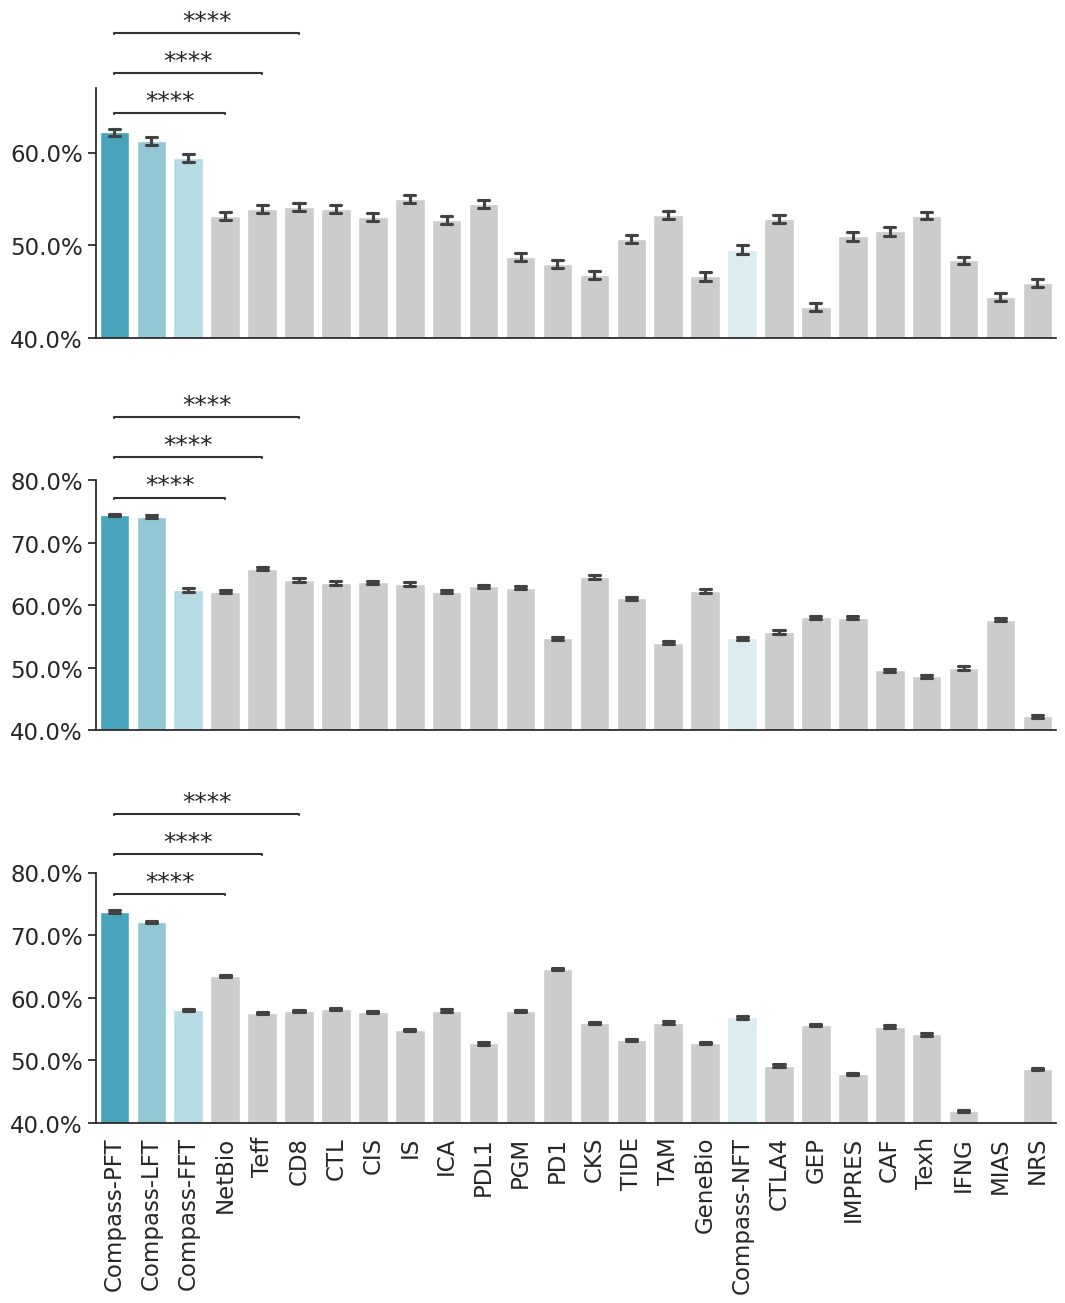

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from statannotations.Annotator import Annotator

# ===== 配色 =====
compass_cmap = {'PFT':'#36AFCE', 'LFT':'#86CFE2','FFT':'#AFDFEB','NFT':'#D7EFF5'}
ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat=1).as_hex()

# 基于实际出现的 mode 构造 palette，未指定的一律灰色
unique_modes = dfp['mode'].unique().tolist()
mode_palette = {m: ot for m in unique_modes}
mode_palette.update({m:c for m,c in {'NFT':f4[0],'LFT':f4[1],'PFT':f4[2],'FFT':f4[3],'PFT2':f4[2]}.items() if m in unique_modes})
mode_palette.update({m:c for m,c in compass_cmap.items() if m in unique_modes})

ylabels = ['6 Small cohorts(n=130)', '6 Medium cohorts(n=331)', '4 Larger cohorts(n=672)']
values = 'ACC'

# 固定 seed（如需聚合可改为先 groupby 再 mean）
dfp_seed = dfp[dfp.seed == 42] if 'seed' in dfp.columns else dfp
dfp_seed.to_csv('./bootstrap_results/performance.tsv', sep ='\t')

# 全局顺序按均值降序（仅基于 seed==42 的子集）
order = (dfp_seed.groupby('mode')[values]
         .mean()
         .sort_values(ascending=False)
         .index.tolist())
result = [item for item in order if item not in ['PFT', 'LFT', 'FFT', 'NFT']]
pairs = [(order[0], i) for i in  result[:3]]

fig, axes = plt.subplots(figsize=(11, 4.5*3), nrows=3, sharex=True)
for s, ylim, ax, title in zip(['small', 'medium', 'large'],
                              [(0.4, 0.67), (0.4, 0.8), (0.4, 0.8)],
                              axes, ylabels):

    dfp1 = dfp_seed[dfp_seed['size_map'] == s].copy()
    if dfp1.empty:
        ax.text(0.5, 0.5, f'No data for {s}', ha='center', va='center', transform=ax.transAxes)
        continue

    # 当前面板实际存在的类别 & 顺序
    present_modes = dfp1['mode'].unique().tolist()
    

    # 条形图（均值 + 95%CI；如想用 SD 可改为 errorbar='sd'）
    sns.barplot(
        data=dfp1, x='mode', y=values,
        order=order, width=0.8, capsize=0.3, estimator=np.mean,
        ax=ax, palette=mode_palette, errorbar= 'se'#("ci", 95)
    )

    # 轴/外观
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.set_title(title)
    
    ax.set_ylim(*ylim)  # 先锁住范围
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.tick_params(axis='y', which='major', right=False, top=False, direction='out', reset=True)

    # X 轴标签（若你有 label_map）
    ax.set_xlim(-0.5, len(order) - 0.5)
    ax.set_xticklabels(label_map(order), rotation=90)
    

    span = ylim[1] - ylim[0]
    annot = Annotator(
        ax, pairs,
        data=dfp1, x='mode', y=values,
        order=order, width=0.8
    )
    # 更通用：Mann-Whitney（两独立样本）；若你有严格的配对（按 cohort），建议自己用 scipy 先算 Wilcoxon 再手动画括号
    annot.configure(
        test='Wilcoxon',
        comparisons_correction='fdr_bh',  # 如需多重校正可打开
        text_format='star',
        show_test_name=False,
        # 缩小层间距，避免改变 ylim
        line_offset=0.006 * span,
        line_height=0.010 * span,
        text_offset=0.003 * span,
    )
    annot.apply_and_annotate()
    # 防止 Annotator 自动抬高 ylim：强制恢复
    ax.set_ylim(*ylim)

fig.tight_layout()
fig.savefig(f'./bootstrap_results/group_bar_{values}.svg', bbox_inches='tight', dpi=150)
fig.savefig(f'./bootstrap_results/group_bar_{values}.pdf', bbox_inches='tight', dpi=150)

In [18]:
dfps = dfp_seed
x1 = dfps.groupby(['mode', 'size_map']).ACC.mean().sort_values(ascending=False).round(3).unstack().T[order]
std = dfps.groupby(['mode', 'size_map']).ACC.std().sort_values(ascending=False).round(3).unstack().T[order]
ACC_result = x1.astype(str)  # 先转换 mean 为字符串
for col in x1.columns:
    ACC_result[col] = x1[col].astype(str)  # 先转换 mean 为字符串
    ACC_result[col] = ACC_result[col] + std[col].apply(lambda x: f" ± {x}" if pd.notna(x) and x > 0 else "")

x1 = dfps.groupby(['mode', 'size_map']).MCC.mean().sort_values(ascending=False).round(3).unstack().T[order]
std = dfps.groupby(['mode', 'size_map']).MCC.std().sort_values(ascending=False).round(3).unstack().T[order]
MCC_result = x1.astype(str)  # 先转换 mean 为字符串
for col in x1.columns:
    MCC_result[col] = x1[col].astype(str)  # 先转换 mean 为字符串
    MCC_result[col] = MCC_result[col] + std[col].apply(lambda x: f" ± {x}" if pd.notna(x) and x > 0 else "")

x1 = dfps.groupby(['mode', 'size_map']).PRC.mean().sort_values(ascending=False).round(3).unstack().T[order]
std = dfps.groupby(['mode', 'size_map']).PRC.std().sort_values(ascending=False).round(3).unstack().T[order]
PRC_result = x1.astype(str)  # 先转换 mean 为字符串
for col in x1.columns:
    PRC_result[col] = x1[col].astype(str)  # 先转换 mean 为字符串
    PRC_result[col] = PRC_result[col] + std[col].apply(lambda x: f" ± {x}" if pd.notna(x) and x > 0 else "")

ACC_result['Metric'] = 'ACC'
MCC_result['Metric'] = 'MCC'
PRC_result['Metric'] = 'PRC'

metric = ACC_result._append(MCC_result)._append(PRC_result).reset_index()
metric.set_index('Metric','size_map', ).T.to_excel('./bootstrap_results/loco_group_bootstrap.xlsx')

In [19]:
errorbar = 'se'

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PFT vs. NetBio: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.043e-07 Stat=9.780e+02
PFT vs. GEP: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:4.221e-14 Stat=3.280e+02
PFT vs. CTL: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.657e-05 Stat=1.391e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PFT vs. NetBio: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.897e-18 Stat=0.000e+00
PFT vs. GEP: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.897e-18 Stat=0.000e+00
PFT vs. CTL: Wilcoxon test (paired samples) with Benjam

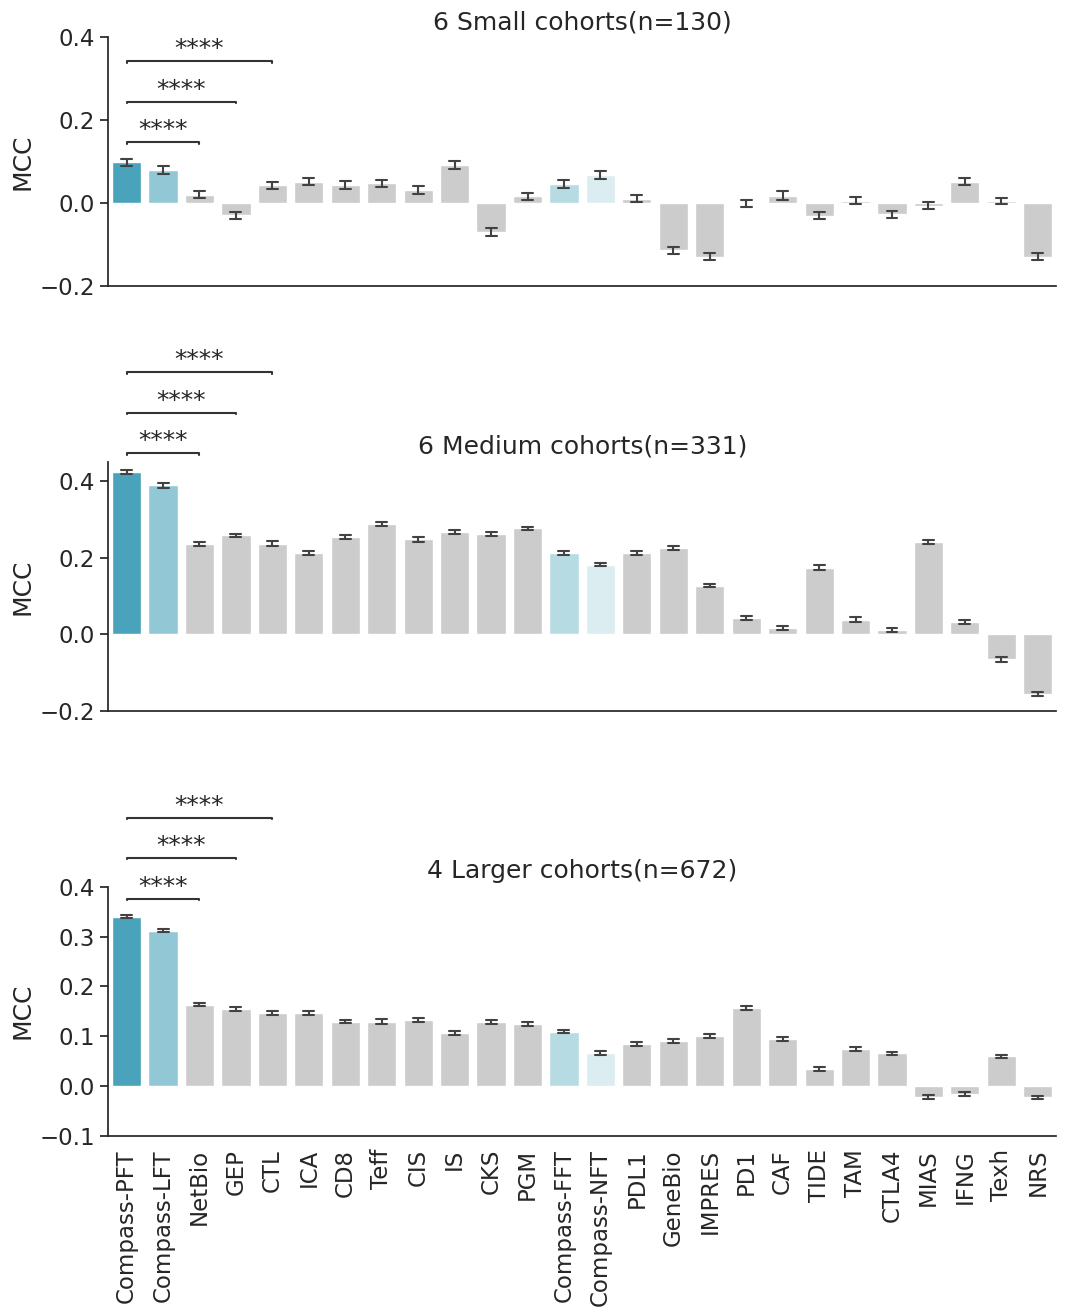

In [20]:
values = 'MCC'

order = (dfp_seed.groupby('mode')[values]
         .median()
         .sort_values(ascending=False)
         .index.tolist())
result = [item for item in order if item not in ['PFT', 'LFT', 'FFT', 'NFT']]
pairs = [(order[0], i) for i in  result[:3]]

fig, axes = plt.subplots(figsize=(11, 4.5*3), nrows=3, sharex=True)
for s, ylim, ax, title in zip(['small', 'medium', 'large'],
                              [(-0.2, 0.4), (-0.2, 0.45), (-0.1, 0.4)],
                              axes, ylabels):

    dfp1 = dfp_seed[dfp_seed['size_map'] == s].copy()
    if dfp1.empty:
        ax.text(0.5, 0.5, f'No data for {s}', ha='center', va='center', transform=ax.transAxes)
        continue

    # 当前面板实际存在的类别 & 顺序
    present_modes = dfp1['mode'].unique().tolist()
    

    # 条形图（均值 + 95%CI；如想用 SD 可改为 errorbar='sd'）
    sns.barplot(
        data=dfp1, x='mode', y=values,
        order=order, width=0.8, capsize=0.3, estimator=np.mean, errwidth = 1.5,
        ax=ax, palette=mode_palette, errorbar=errorbar #("ci", 95)
    )

    # 轴/外观
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(title)
    
    ax.set_ylim(*ylim)  # 先锁住范围
    #ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.tick_params(axis='y', which='major', right=False, top=False, direction='out', reset=True)

    # X 轴标签（若你有 label_map）
    ax.set_xlim(-0.5, len(order) - 0.5)
    ax.set_xticklabels(label_map(order), rotation=90)
    
    #ax.tick_params(axis='x', which='major', direction='out', reset=True)
    ax.set_ylabel(values)
    

    span = ylim[1] - ylim[0]
    annot = Annotator(
        ax, pairs,
        data=dfp1, x='mode', y=values,
        order=order, width=0.8
    )
    # 更通用：Mann-Whitney（两独立样本）；若你有严格的配对（按 cohort），建议自己用 scipy 先算 Wilcoxon 再手动画括号
    annot.configure(
        test='Wilcoxon',
        comparisons_correction='fdr_bh',  # 如需多重校正可打开
        text_format='star',
        show_test_name=False,
        # 缩小层间距，避免改变 ylim
        line_offset=0.006 * span,
        line_height=0.010 * span,
        text_offset=0.003 * span,
    )
    annot.apply_and_annotate()
    # 防止 Annotator 自动抬高 ylim：强制恢复
    ax.set_ylim(*ylim)

fig.tight_layout()
fig.savefig(f'./bootstrap_results/group_bar_{values}.svg', bbox_inches='tight', dpi=150)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LFT vs. GEP: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:7.117e-18 Stat=2.000e+01
LFT vs. PGM: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:5.887e-11 Stat=6.210e+02
LFT vs. Teff: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:7.343e-04 Stat=1.543e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LFT vs. GEP: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.962e-12 Stat=5.070e+02
LFT vs. PGM: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.375e-09 Stat=7.630e+02
LFT vs. Teff: Wilcoxon test (paired samples) with Benjamini-

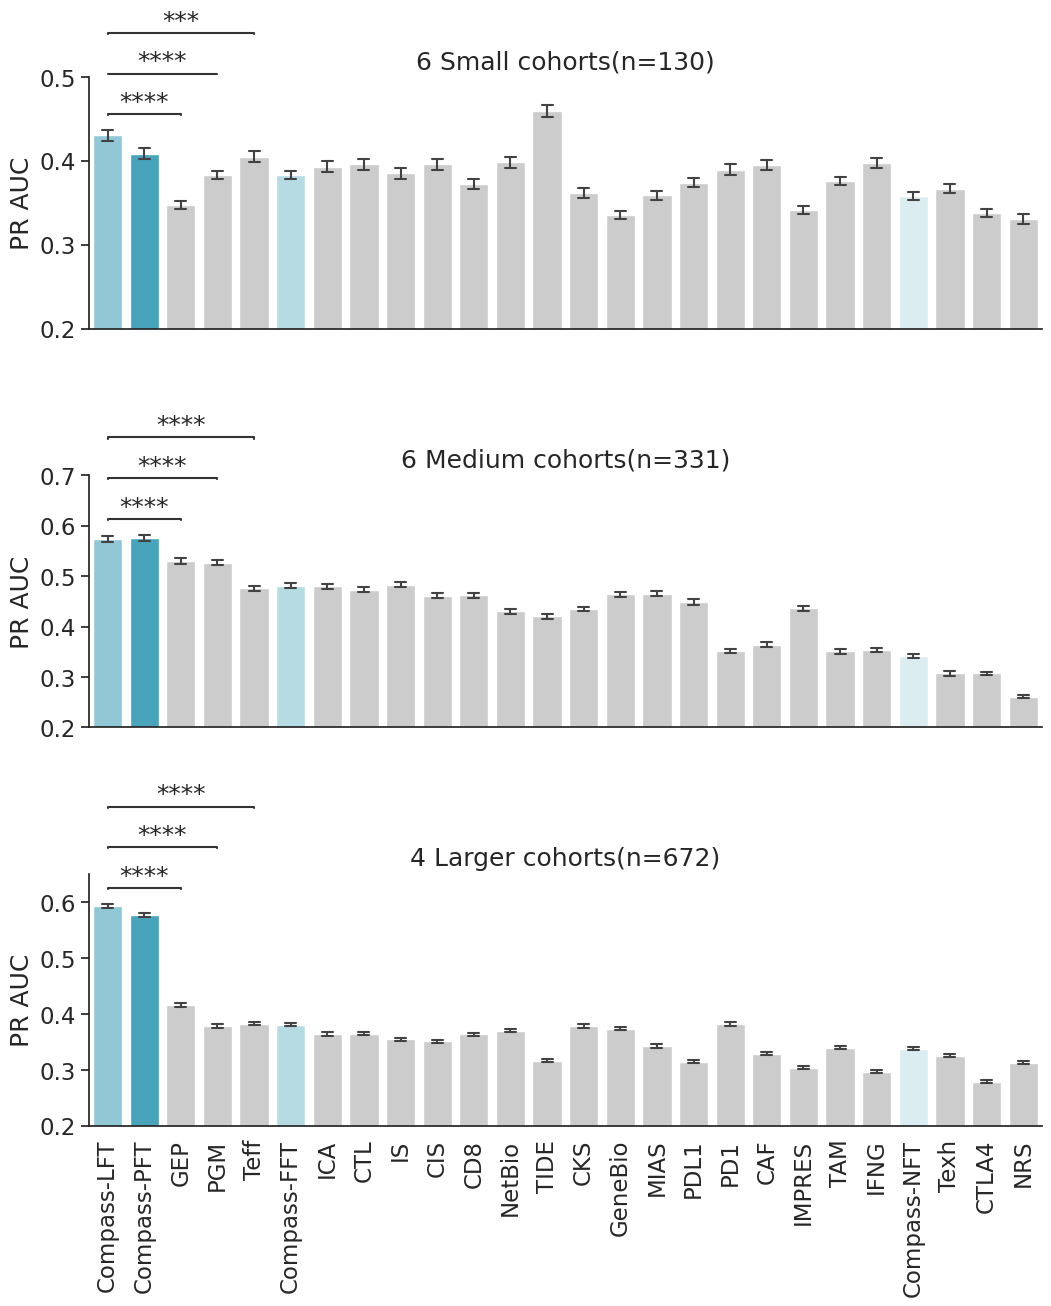

In [21]:
values = 'PRC'

order = (dfp_seed.groupby('mode')[values]
         .mean()
         .sort_values(ascending=False)
         .index.tolist())
result = [item for item in order if item not in ['PFT', 'LFT', 'FFT', 'NFT']]
pairs = [(order[0], i) for i in  result[:3]]

fig, axes = plt.subplots(figsize=(11, 4.5*3), nrows=3, sharex=True)
for s, ylim, ax, title in zip(['small', 'medium', 'large'],
                              [(0.2, 0.5), (0.2, 0.7), (0.2, 0.65)],
                              axes, ylabels):

    dfp1 = dfp_seed[dfp_seed['size_map'] == s].copy()
    if dfp1.empty:
        ax.text(0.5, 0.5, f'No data for {s}', ha='center', va='center', transform=ax.transAxes)
        continue

    # 当前面板实际存在的类别 & 顺序
    present_modes = dfp1['mode'].unique().tolist()
    

    # 条形图（均值 + 95%CI；如想用 SD 可改为 errorbar='sd'）
    sns.barplot(
        data=dfp1, x='mode', y=values,
        order=order, width=0.8, capsize=0.3, estimator=np.mean, errwidth = 1.5,
        ax=ax, palette=mode_palette, errorbar= errorbar#
    )

    # 轴/外观
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(title)
    
    ax.set_ylim(*ylim)  # 先锁住范围
    #ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.tick_params(axis='y', which='major', right=False, top=False, direction='out', reset=True)

    # X 轴标签（若你有 label_map）
    ax.set_xlim(-0.5, len(order) - 0.5)
    ax.set_xticklabels(label_map(order), rotation=90)
    
    #ax.tick_params(axis='x', which='major', direction='out', reset=True)
    ax.set_ylabel('PR AUC')
    span = ylim[1] - ylim[0]
    annot = Annotator(
        ax, pairs,
        data=dfp1, x='mode', y=values,
        order=order, width=0.8
    )
    # 更通用：Mann-Whitney（两独立样本）；若你有严格的配对（按 cohort），建议自己用 scipy 先算 Wilcoxon 再手动画括号
    annot.configure(
        test='Wilcoxon',
        comparisons_correction='fdr_bh',  # 如需多重校正可打开
        text_format='star',
        show_test_name=False,
        # 缩小层间距，避免改变 ylim
        line_offset=0.006 * span,
        line_height=0.010 * span,
        text_offset=0.003 * span,
    )
    annot.apply_and_annotate()
    # 防止 Annotator 自动抬高 ylim：强制恢复
    ax.set_ylim(*ylim)

fig.tight_layout()
fig.savefig(f'./bootstrap_results/group_bar_{values}.svg', bbox_inches='tight', dpi=150)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PFT vs. PGM: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.202e-01 Stat=2.073e+03
PFT vs. NetBio: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.115e-01 Stat=2.117e+03
PFT vs. GEP: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.997e-08 Stat=9.280e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PFT vs. PGM: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:4.266e-18 Stat=3.000e+00
PFT vs. NetBio: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.897e-18 Stat=0.000e+00
PFT vs. GEP: Wilcoxon test (paired samples) with Benjam

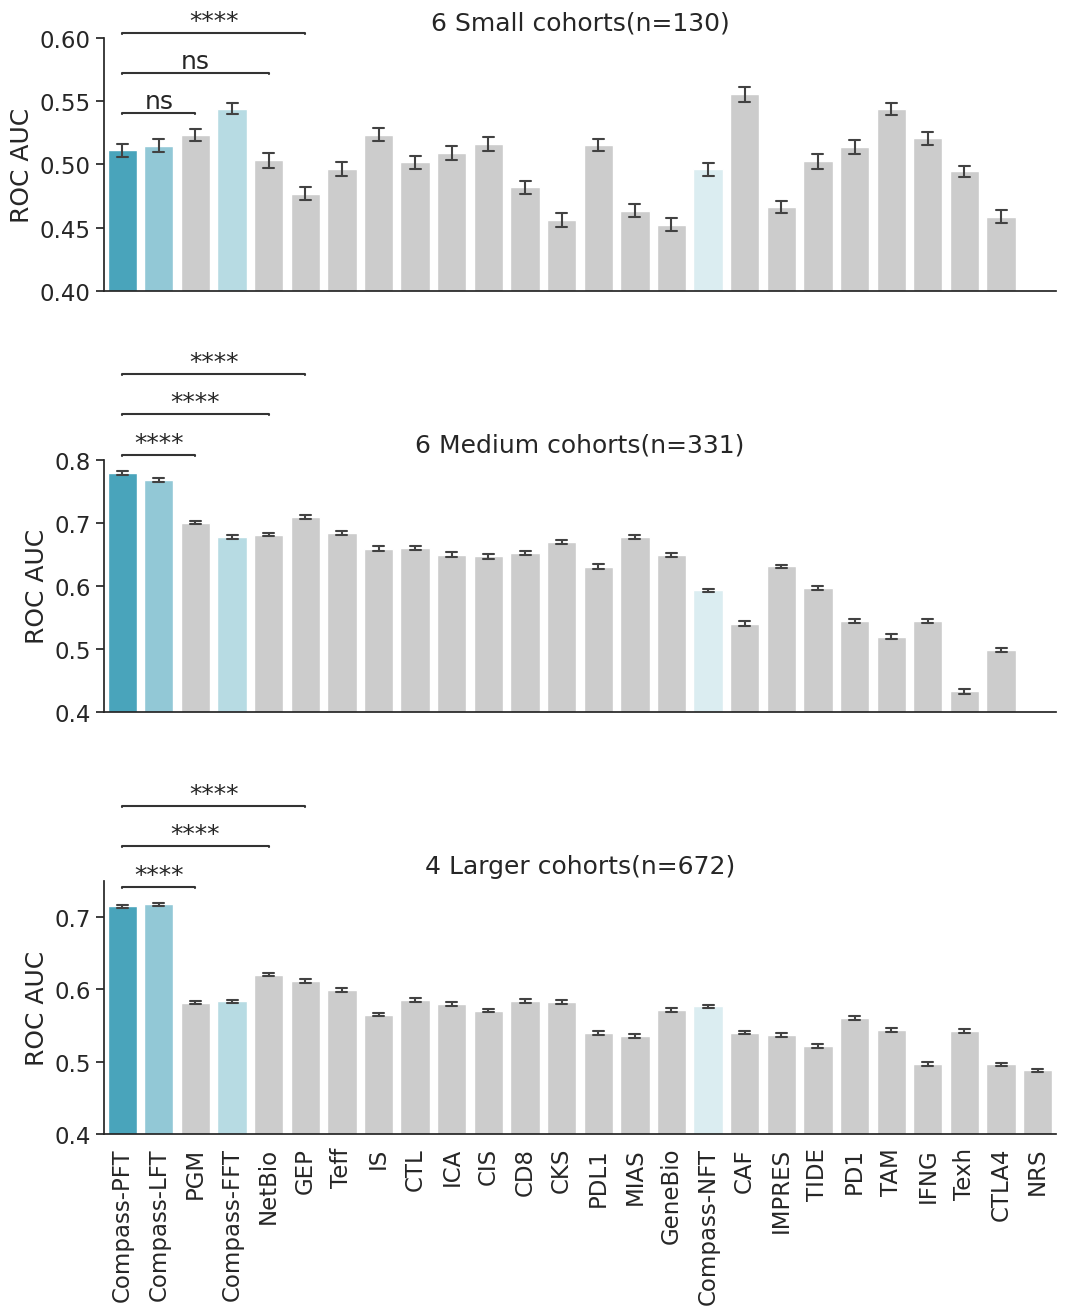

In [22]:
values = 'ROC'

order = (dfp_seed.groupby('mode')[values]
         .mean()
         .sort_values(ascending=False)
         .index.tolist())
result = [item for item in order if item not in ['PFT', 'LFT', 'FFT', 'NFT']]
pairs = [(order[0], i) for i in  result[:3]]

fig, axes = plt.subplots(figsize=(11, 4.5*3), nrows=3, sharex=True)
for s, ylim, ax, title in zip(['small', 'medium', 'large'],
                              [(0.4, 0.6), (0.4, 0.8), (0.4, 0.75)],
                              axes, ylabels):

    dfp1 = dfp_seed[dfp_seed['size_map'] == s].copy()
    if dfp1.empty:
        ax.text(0.5, 0.5, f'No data for {s}', ha='center', va='center', transform=ax.transAxes)
        continue

    # 当前面板实际存在的类别 & 顺序
    present_modes = dfp1['mode'].unique().tolist()
    

    # 条形图（均值 + 95%CI；如想用 SD 可改为 errorbar='sd'）
    sns.barplot(
        data=dfp1, x='mode', y=values,
        order=order, width=0.8, capsize=0.3, estimator=np.mean, errwidth = 1.5,
        ax=ax, palette=mode_palette, errorbar= errorbar#
    )

    # 轴/外观
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(title)
    
    ax.set_ylim(*ylim)  # 先锁住范围
    #ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.tick_params(axis='y', which='major', right=False, top=False, direction='out', reset=True)

    # X 轴标签（若你有 label_map）
    ax.set_xlim(-0.5, len(order) - 0.5)
    ax.set_xticklabels(label_map(order), rotation=90)
    
    #ax.tick_params(axis='x', which='major', direction='out', reset=True)
    ax.set_ylabel('ROC AUC')
    span = ylim[1] - ylim[0]
    annot = Annotator(
        ax, pairs,
        data=dfp1, x='mode', y=values,
        order=order, width=0.8
    )
    # 更通用：Mann-Whitney（两独立样本）；若你有严格的配对（按 cohort），建议自己用 scipy 先算 Wilcoxon 再手动画括号
    annot.configure(
        test='Wilcoxon',
        comparisons_correction='fdr_bh',  # 如需多重校正可打开
        text_format='star',
        show_test_name=False,
        # 缩小层间距，避免改变 ylim
        line_offset=0.006 * span,
        line_height=0.010 * span,
        text_offset=0.003 * span,
    )
    annot.apply_and_annotate()
    # 防止 Annotator 自动抬高 ylim：强制恢复
    ax.set_ylim(*ylim)

fig.tight_layout()
fig.savefig(f'./bootstrap_results/group_bar_{values}.svg', bbox_inches='tight', dpi=150)
